### This is the playground to test and develop

In [ ]:
# hey can you read this? what is your name?
# yes, I can read this. my name is Assistant.

# do you know what this code is supposed to do?
# this is supposed to simulate the AKLT using the MPS method and iTEBD and imaginary time.
# can we do that?

# yes, we can do that. we will use the iTEBD algorithm to simulate the AKLT model in imaginary time.

# perfect, let us go through the code step by step and few lines at a time.
# sure, let's start with the imports and the initial setup.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, svd
import quimb as qu

class IMPS:
    def __init__(self, d, chi):

        # initializing the dimension of the local hilbert space: spin 1 sites --> d = 3
        # initializing the maximum bond dimension chi. 2 is enough for the AKLT model.
        # bond dimension is not dynamic and will not change in this code but we can implement that as well.
        # we have 2 sites only which are repeated indefinitely. we call them L and R and we initialize them randomly.
        # I am considering the L and R as kets here

        self.d = d
        self.chi = chi
        self.spin = (self.d-1)*1/2
        self.Sx, self.Sy, self.Sz = self.spin_ops()
        self.L = np.random.randn(chi, d, chi) + 1j * np.random.randn(chi, d, chi)
        self.R = np.random.randn(chi, d, chi) + 1j * np.random.randn(chi, d, chi)

        self.L /= np.linalg.norm(self.L)
        self.R /= np.linalg.norm(self.R)
        self.U = None

    def spin_ops(self):

        # spin operators are 3 by 3 matrices here. we import them from quimb.

        Sx = qu.spin_operator('x', self.spin)
        Sy = qu.spin_operator('y', self.spin)
        Sz = qu.spin_operator('z', self.spin)

        return Sx, Sy, Sz
    
    def aklt_2site_hamiltonian(self):
        Sx, Sy, Sz = self.Sx, self.Sy, self.Sz
        
        # we are just doing a tensor product and summing to get the first term in the Hamiltonian
        # we could also use np.kron here but this gives us a chance to see how the indices are being manipulated
        # look at the first term of the SdotS. note that i and k are kets of the operator Sx for site L and j and l are the bras of the operator Sx for site R
        # we put i next to k and j next to l so that we can keep track of how we are contracting them
        # the result is a 3 by 3 by 3 by 3 by 3 matrix. reshaping this into a 9 by 9 matrix just gives us Sx_L ⊗ Sx_R

        SdotS = (
        np.einsum('ij,kl->ikjl', Sx, Sx) +
        np.einsum('ij,kl->ikjl', Sy, Sy) +
        np.einsum('ij,kl->ikjl', Sz, Sz)
        )

        SdotS = SdotS.reshape(self.d**2, self.d**2)

        # now we need to add the second term to the Hamiltonian.
        H = SdotS + 1/3 * SdotS@SdotS


        # this is what the hamiltonian should look like, although as a 9 by 9 matrix and not in the MPO form
        # we might need to reshape it later, but we can exponentiate rank 2 matrices so we return it as a matrix

        return H
    
    def time_evolution_operator(self, dt, imaginary=True):

        # we exponentiate and reshape to get a time evolution operator U which has 4 indices
        # the first two are kets corresponding to each site and the last two are bras and can be contracted with the kets

        H = self.aklt_2site_hamiltonian()
        if imaginary:
            U = expm( -dt * H )
        else:
            U = expm(-1j * dt * H)
        return U.reshape(self.d, self.d, self.d, self.d)
    
    def contract_and_evolve(self, dt, steps):
        U = self.time_evolution_operator(dt)
        self.U = U
        enpb = []


        
        for _ in range(steps):

            # for each step, we contract the L and R over their bond, leaving us with a tensor of shape (chi, d, d, chi)
            # this is necessary because the time evoolution operator acts on pairs of neighboring sites
            LR = np.einsum('ijk,klm->ijlm', self.L, self.R)


            # we then contract this with the time evolution operator U. note that the bras of U __k,l__ are contracted with the kets of LR, also named __k,l__. leaving a,i,j,b untouched
            LR = np.einsum('ijkl,aklb->aijb', U, LR)


            # in this step we apply svd and truncate with the same chi. this is undoing what we did in the first step.
            u, s, v = svd(LR.reshape(self.chi * self.d, self.chi * self.d))

            u = u[:, :self.chi]
            s = s[:self.chi]
            v = v[:self.chi, :]
            
            sqrt_s = np.diag(np.sqrt(s))
            u_combined = u @ sqrt_s
            v_combined = sqrt_s @ v

            self.L = u_combined.reshape(self.chi, self.d, self.chi)
            self.R = v_combined.reshape(self.chi, self.d, self.chi)

            # just computing the energy per pair of sites here
            enpb.append(self.compute_energy_per_bond(self.aklt_2site_hamiltonian().reshape(self.d, self.d, self.d, self.d)))

        return enpb
    
    def compute_energy_per_bond(self, H):


        # this is also a nice example of how np.einsum works.
        # we get the LR just like we did before but we call it the ket here
        # we get the bra as the conjugate of the ket

        ket = np.einsum('iaj,jbk->iabk', self.L, self.R)
        bra = np.conj(ket)


        # the hamiltonian here is 3 by 3 by 3 by 3 and we need to contract it with the ket and bra. just as we get the expectation value
        # the kets of H: ij, the bras of H: kl. so these indices are contracted with the indices of the bra of and the ket respectively which have the same names
        # finally we have the a and b which are the bond indices. these indices contract with themselves and we get a scalar


        numerator = np.einsum('aijb,ijkl,aklb->',bra, H, ket)
        norm = np.einsum('ijab,ijab->', bra, ket)

        return np.real(numerator / norm)
    




if __name__ == "__main__":


    d = 3
    chi = 2 # higher chi makes no difference, chi = 1 messes up the simulation
    tau = 0.01
    steps = 1500


    mps = IMPS(d, chi)
    H2 = mps.aklt_2site_hamiltonian()

    energies_after_each_step = mps.contract_and_evolve(tau, steps)        

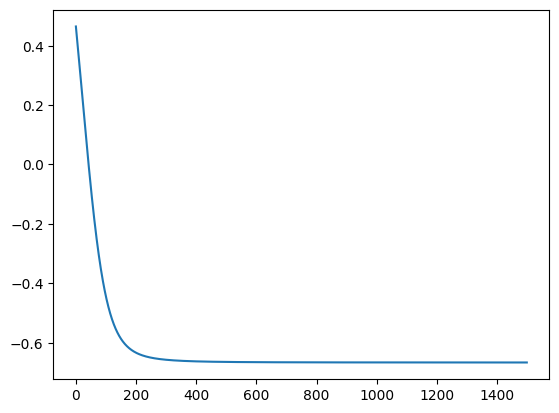

In [214]:
plt.plot(energies_after_each_step) #imaginay time gives us the pretty exponential decay

In [215]:
energies_after_each_step[-1] # this should be the ground state energy per bond afaik. I am not sure about this though.

np.float64(-0.6666308462665643)